# Step 1: Setup and Import Libraries

We install and import the necessary packages.
- `nba_api` to pull data from NBA
- `pandas` for data manipulation

To start, we pull all games from the 2023–24 NBA season and filter out games that went into overtime.


In [ ]:
!pip install nba_api

from nba_api.stats.endpoints import leaguegamefinder, boxscoretraditionalv2, boxscoresummaryv2
import pandas as pd
import time

# Step 2: Pulling an Overtime Game as a Case Study

We use `leaguegamefinder` to pull all NBA games from the 2023–24 season, then filter for games that likely went to overtime. Games with more than 240 total minutes played suggest overtime.

We selected one as a case study


In [ ]:
# First, pull all games from the 2023–24 season
from nba_api.stats.endpoints import leaguegamefinder

gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2023-24',league_id_nullable='00')
games_df = gamefinder.get_data_frames()[0]

# Filter to the Dallas vs. Houston game on April 7, 2024
selected = games_df[(games_df['GAME_DATE'] == '2024-04-07') & (games_df['MATCHUP'] == 'DAL vs. HOU')]

# Grab its GAME_ID
game_id = selected.iloc[0]['GAME_ID']

# Display TEAM_NAME, PTS and WL instead of HOME_TEAM_NAME/VISITOR_TEAM_NAME for readability
print("Selected game details:")
print(selected[['GAME_DATE', 'MATCHUP', 'TEAM_NAME', 'PTS', 'WL']])

Selected game details:
      GAME_DATE      MATCHUP         TEAM_NAME  PTS WL
310  2024-04-07  DAL vs. HOU  Dallas Mavericks  147  W


# Step 3: Pull Game Details (Box Score and Quarter Breakdown)

Now that we’ve identified a specific overtime game, we use two endpoints:

- `boxscoretraditionalv2`: for player performance and team totals.
- `boxscoresummaryv2`: for quarter-by-quarter scoring.

We'll use this information to calculate our custom **Entertainment Index** based on:
- Score differential in the 4th quarter
- Star player performance
- Comeback or late-game drama


In [ ]:
# Get box score and summary data for the selected game
boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id)
summary = boxscoresummaryv2.BoxScoreSummaryV2(game_id=game_id)

# Player-level stats
player_stats = boxscore.get_data_frames()[0]

# Correct team-level quarter scores (LINE_SCORE is at index 5)
line_score = summary.get_data_frames()[5]

# If PTS_OT1 doesn't exist (rare), set it to 0
if 'PTS_OT1' not in line_score.columns:
    line_score['PTS_OT1'] = 0

# Define team1/team2 from line_score
team1 = line_score.iloc[0]
team2 = line_score.iloc[1]

# Display relevant info
line_score[['TEAM_ABBREVIATION', 'PTS_QTR1', 'PTS_QTR2', 'PTS_QTR3', 'PTS_QTR4', 'PTS_OT1', 'PTS']]

,TEAM_ABBREVIATION,PTS_QTR1,PTS_QTR2,PTS_QTR3,PTS_QTR4,PTS_OT1,PTS
0,DAL,27,39,32,31,18,147
1,HOU,42,29,35,23,7,136


# Step 4: Calculate the Entertainment Index

Our custom metric combines:
- A tight score differential in Q4 (closer = more exciting)
- At least one star player performance (e.g., 30+ points)
- Overtime bonus (OT = auto boost)
- Comeback detection: trailing at halftime but won the game

We also factor in game dynamics like:
- Lead changes
- Clutch-time performance
- Final-minute shot attempts

Each component is normalized and contributes to a final score.


In [ ]:
from nba_api.stats.endpoints import playbyplayv2
import pandas as pd
import numpy as np

# The play-by-play preprocess
pbp = playbyplayv2.PlayByPlayV2(game_id=game_id)
pbp_df = pbp.get_data_frames()[0]
pbp_df['SCOREMARGIN'] = pd.to_numeric(pbp_df['SCOREMARGIN'], errors='coerce')
pbp_df['SECONDS_LEFT'] = (pbp_df['PCTIMESTRING'].str.split(':').str[0].astype(float) * 60 + pbp_df['PCTIMESTRING'].str.split(':').str[1].astype(float))

# Total-Game Close Score Bonus (tiered on final margin)
final_diff = abs(team1['PTS'] - team2['PTS'])
if final_diff <= 5:
    diff_score = 95
elif final_diff <= 10:
    diff_score = 85
elif final_diff <= 20:
    diff_score = 30
else:
    diff_score = 0

# Star Performance (30+ points gives 75 points each)
num_star_30 = len(player_stats[player_stats['PTS'] >= 30])
star_score = 75 * num_star_30

# Big Comeback (down ≥20 at half & win gives 88 points)
half1_t1 = team1['PTS_QTR1'] + team1['PTS_QTR2']
half1_t2 = team2['PTS_QTR1'] + team2['PTS_QTR2']
down_by = abs(half1_t1 - half1_t2)
leader_at_half = 'team1' if half1_t1 > half1_t2 else 'team2'
winner = 'team1' if team1['PTS'] > team2['PTS'] else 'team2'
was_big_comeback = (down_by >= 20 and leader_at_half != winner)
comeback_score = 88 if was_big_comeback else 0

# Overtime Bonus (any OT points gives 98 points)
ot_score = 98 if (team1.get('PTS_OT1', 0) > 0 or team2.get('PTS_OT1', 0) > 0) else 0

# True Lead-Flips Calculation
pbp_df['SCOREMARGIN_NUM'] = pbp_df['SCOREMARGIN']
pbp_df['SIGN'] = pbp_df['SCOREMARGIN_NUM'].apply(lambda x: 1 if x>0 else (-1 if x<0 else np.nan))
pbp_df['PREV_SIGN'] = pbp_df['SIGN'].shift()
pbp_df['FLIP'] = (pbp_df['SIGN'] * pbp_df['PREV_SIGN'] == -1)
pbp_df['HALF'] = pbp_df['PERIOD'].apply(lambda p: 1 if p<=2 else 2)

first_half_flips = int(pbp_df[(pbp_df['HALF']==1) & pbp_df['FLIP']].shape[0])
second_half_flips = int(pbp_df[(pbp_df['HALF']==2) & pbp_df['FLIP']].shape[0])
first_half_score = 15 * first_half_flips
second_half_score = 25 * second_half_flips

# Final-Minute FGAs (last 5 min Q4, margin <10)
fga_plays = pbp_df[(pbp_df['PERIOD']==4) & (pbp_df['SECONDS_LEFT']<=300) & (pbp_df['EVENTMSGTYPE']==1) & (pbp_df['SCOREMARGIN_NUM'].abs()<10)]

attempts = len(fga_plays)
made = 0
for idx, row in fga_plays.iterrows():
    old = row['SCOREMARGIN_NUM']
    nxt = pbp_df.loc[idx+1:, 'SCOREMARGIN_NUM'].dropna().iloc[0]
    if abs(nxt) != abs(old):
        made += 1
attempts_score = 15 * attempts
makes_score    = 30 * made

# Pressure Makes: every made FG or FT (EVENTMSGTYPE 1 or 3) with margin<10 ⇒ 10 points each
pressure_makes = pbp_df[(pbp_df['EVENTMSGTYPE'].isin([1,3])) & (pbp_df['SCOREMARGIN_NUM'].abs() < 10)].shape[0]
pressure_score = 10 * pressure_makes

# Final Entertainment Index
entertainment_score = (diff_score + star_score + comeback_score + ot_score + first_half_score + second_half_score + attempts_score + makes_score + pressure_score)

# Print Detailed Breakdown
print("Final Metric Breakdown (0–100+ scale):")
print(f"Total-Game Close Bonus: {diff_score} (margin={final_diff})")
print(f"Star 30+ (×75 each): {star_score}  ({num_star_30} player(s))")
print(f"Big Comeback (≥20↓): {comeback_score}")
print(f"Overtime Bonus: {ot_score}")
print(f"1H Lead-Flips (×15): {first_half_flips} → {first_half_score}")
print(f"2H Lead-Flips (×25): {second_half_flips} → {second_half_score}")
print(f"FGA Attempts (×15): {attempts} → {attempts_score}")
print(f"Makes in those FGAs (×30): {made} → {makes_score}")
print(f"Pressure Makes (×10): {pressure_makes} → {pressure_score}")
print(f"\nFinal Entertainment Index: {entertainment_score}")

# Show true flip events for verification
flip_events = pbp_df[pbp_df['FLIP']][['PERIOD','PCTIMESTRING','SCOREMARGIN_NUM','SIGN','PREV_SIGN','EVENTMSGTYPE','HOMEDESCRIPTION','VISITORDESCRIPTION']]

display(flip_events)
print("Total true lead-flips:", flip_events.shape[0])

Final Metric Breakdown (0–100+ scale):
Total-Game Close Bonus: 30 (margin=11)
Star 30+ (×75 each): 150  (2 player(s))
Big Comeback (≥20↓): 0
Overtime Bonus: 98
1H Lead-Flips (×15): 0 → 0
2H Lead-Flips (×25): 4 → 100
FGA Attempts (×15): 6 → 90
Makes in those FGAs (×30): 3 → 90
Pressure Makes (×10): 88 → 880

Final Entertainment Index: 1438


,PERIOD,PCTIMESTRING,SCOREMARGIN_NUM,SIGN,PREV_SIGN,EVENTMSGTYPE,HOMEDESCRIPTION,VISITORDESCRIPTION
458,4,2:42,-2.0,-1.0,1.0,1,None,Brooks 3PT Jump Shot (26 PTS) (Ja. Green 8 AST)
464,4,1:24,-1.0,-1.0,1.0,1,None,Smith Jr. 13' Driving Floating Jump Shot (12 P...
465,4,1:10,1.0,1.0,-1.0,1,Irving 1' Cutting Layup Shot (42 PTS) (Exum 2 ...,None
466,4,0:58,-2.0,-1.0,1.0,1,None,Bullock Jr. 25' 3PT Jump Shot (11 PTS) (VanVle...


Total true lead-flips: 4


### Visualizing the Entertainment Index Components

Below, we create a horizontal bar chart showing how much each metric contributed to the final Entertainment Index for the BOS vs. DAL game. Each bar’s length represents the **point contribution** from that metric:

- **Total-Game Closeness**  
- **Star Performances**  
- **Big Comeback**  
- **Overtime Bonus**  
- **1H Lead-Flips**  
- **2H Lead-Flips**  
- **Final-Minute FGA Attempts**  
- **Final-Minute FGA Makes**  
- **Pressure Makes**  

This gives a clear, side-by-side comparison of which moments drove the excitement score the most.


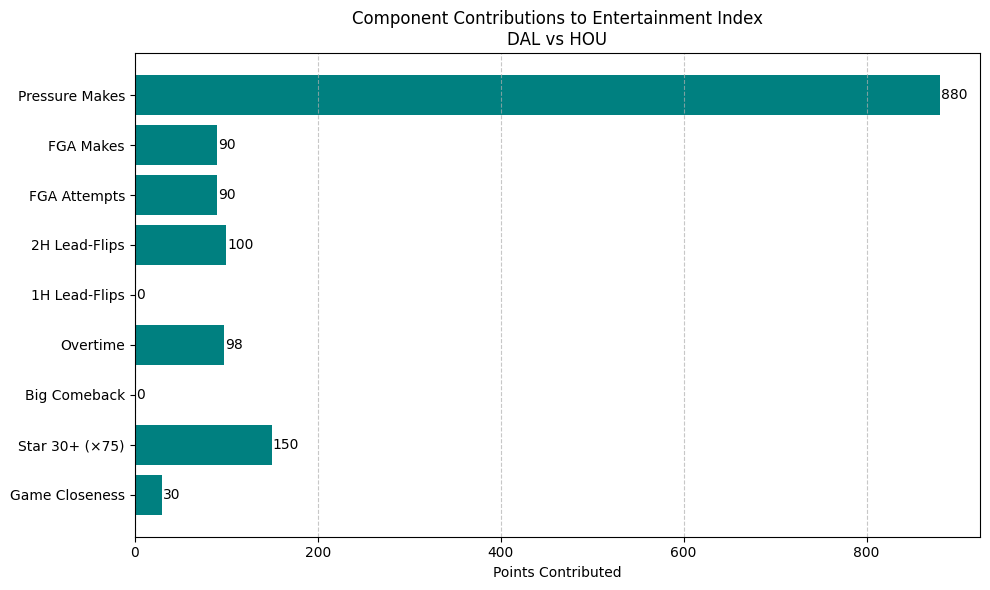

In [ ]:
import matplotlib.pyplot as plt

# Recompute star_score to ensure it's up-to-date in this cell:
# If your “star” threshold is 30+ points:
num_star_30 = len(player_stats[player_stats['PTS'] >= 30])
star_score  = 75 * num_star_30

# Or if you meant 40+, swap to:
# num_star_40 = len(player_stats[player_stats['PTS'] >= 40])
# star_score  = 75 * num_star_40

components = {
    'Game Closeness': diff_score,
    'Star 30+ (×75)': star_score,
    'Big Comeback': comeback_score,
    'Overtime': ot_score,
    '1H Lead-Flips': first_half_score,
    '2H Lead-Flips': second_half_score,
    'FGA Attempts': attempts_score,
    'FGA Makes': makes_score,
    'Pressure Makes': pressure_score}

plt.figure(figsize=(10, 6))
bars = plt.barh(list(components.keys()), list(components.values()), color='teal')
plt.title("Component Contributions to Entertainment Index\nDAL vs HOU")
plt.xlabel("Points Contributed")
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    w = bar.get_width()
    plt.text(w + 1, bar.get_y() + bar.get_height()/2, f"{w:.0f}", va='center')

plt.tight_layout()
plt.show()

# Step 5: Entertainment Index Across a Full Season

We now expand our analysis to look at a full NBA season for the selected team:

For each game, we will:
- Pull game and player data
- Calculate the Entertainment Index
- Store results in a DataFrame
- Visualize how the entertainment levels varied throughout the season


In [ ]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder, boxscoretraditionalv2, boxscoresummaryv2, playbyplayv2
import pandas as pd
import time

# Get Dallas Mavericks' team ID
nba_teams = teams.get_teams()
dallas = [team for team in nba_teams if team['full_name'] == 'Dallas Mavericks'][0]
team_name = dallas['abbreviation']
team_id = dallas['id']

# Pull only regular season games for 2023–24
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id, season_nullable='2023-24')
team_games = gamefinder.get_data_frames()[0]
team_games = team_games[team_games['GAME_ID'].str.startswith('002')]
team_games = team_games.sort_values(by='GAME_DATE', ascending=False)

# Show last 10 games pulled to ensure functionality
print(team_games[['GAME_DATE', 'MATCHUP']].head(10))

# Analyze the last 10 regular season games
entertainment_results = []

for i, row in team_games.head(30).iterrows():
    game_id = row['GAME_ID']
    print(f"Processing game {i + 1}/10 — GAME_ID: {game_id}")

    try:
        boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id).get_data_frames()[0]
        summary = boxscoresummaryv2.BoxScoreSummaryV2(game_id=game_id).get_data_frames()[5]
        pbp_df = playbyplayv2.PlayByPlayV2(game_id=game_id).get_data_frames()[0]

        team1_row = summary.iloc[0]
        team2_row = summary.iloc[1]

        q4_diff = abs(team1_row['PTS_QTR4'] - team2_row['PTS_QTR4'])

        stars = boxscore[boxscore['PTS'] >= 30]
        num_stars = len(stars)

        half1_team1 = team1_row['PTS_QTR1'] + team1_row['PTS_QTR2']
        half1_team2 = team2_row['PTS_QTR1'] + team2_row['PTS_QTR2']
        comeback = ((half1_team1 < half1_team2 and team1_row['PTS'] > team2_row['PTS']) or
                    (half1_team2 < half1_team1 and team2_row['PTS'] > team1_row['PTS']))

        pbp_df['SCOREMARGIN'] = pd.to_numeric(pbp_df['SCOREMARGIN'], errors='coerce')
        lead_changes = pbp_df['SCOREMARGIN'].dropna().ne(pbp_df['SCOREMARGIN'].shift()).sum()

        clutch_plays = pbp_df[
            (pbp_df['PCTIMESTRING'] <= '05:00') &
            (pbp_df['SCOREMARGIN'].abs() <= 5) &
            (pbp_df['EVENTMSGTYPE'].isin([1, 3]))]
        clutch_pts = 0
        for _, play in clutch_plays.iterrows():
            clutch_pts += 2 if play['EVENTMSGTYPE'] == 1 else 1

        final_fgas = pbp_df[(pbp_df['PCTIMESTRING'] <= '01:00') & (pbp_df['EVENTMSGTYPE'] == 1)]
        final_min_fga = len(final_fgas)

        ot_bonus = 1.5 if 'PTS_OT1' in team1_row and team1_row['PTS_OT1'] > 0 else 0

        index = (
            (1 / (q4_diff + 1)) +
            (0.5 * num_stars) +
            (1 if comeback else 0) +
            ot_bonus +
            (0.3 * lead_changes) +
            (0.5 * clutch_pts) +
            (0.1 * final_min_fga))

        entertainment_results.append({
            'GAME_ID': game_id,
            'DATE': row['GAME_DATE'],
            'OPPONENT': row['MATCHUP'],
            'ENTERTAINMENT_INDEX': index})

        time.sleep(1.2)  # avoid NBA API rate-limiting

    except Exception as e:
        print(f"Skipped {game_id} due to error: {e}")
        continue

# Convert the information to a DataFrame and display first 10
entertainment_df = pd.DataFrame(entertainment_results)
entertainment_df.head(10)

     GAME_DATE      MATCHUP
22  2024-04-14    DAL @ OKC
23  2024-04-12  DAL vs. DET
24  2024-04-10    DAL @ MIA
25  2024-04-09    DAL @ CHA
26  2024-04-07  DAL vs. HOU
27  2024-04-05  DAL vs. GSW
28  2024-04-04  DAL vs. ATL
29  2024-04-02    DAL @ GSW
30  2024-03-31    DAL @ HOU
31  2024-03-29    DAL @ SAC
Processing game 23/10 — GAME_ID: 0022301196
Processing game 24/10 — GAME_ID: 0022301181
Processing game 25/10 — GAME_ID: 0022301161
Processing game 26/10 — GAME_ID: 0022301144
Processing game 27/10 — GAME_ID: 0022301131
Processing game 28/10 — GAME_ID: 0022301097
Processing game 29/10 — GAME_ID: 0022301124
Processing game 30/10 — GAME_ID: 0022300589
Processing game 31/10 — GAME_ID: 0022301083
Processing game 32/10 — GAME_ID: 0022301073
Processing game 33/10 — GAME_ID: 0022301047
Processing game 34/10 — GAME_ID: 0022301041
Processing game 35/10 — GAME_ID: 0022301008
Processing game 36/10 — GAME_ID: 0022300994
Processing game 37/10 — GAME_ID: 0022300978
Processing game 38/10 — GAME_ID:

,GAME_ID,DATE,OPPONENT,ENTERTAINMENT_INDEX
0,0022301196,2024-04-14,DAL @ OKC,138.333333
1,0022301181,2024-04-12,DAL vs. DET,120.142857
2,0022301161,2024-04-10,DAL @ MIA,123.166667
3,0022301144,2024-04-09,DAL @ CHA,136.476923
4,0022301131,2024-04-07,DAL vs. HOU,166.811111
5,0022301097,2024-04-05,DAL vs. GSW,145.400000
6,0022301124,2024-04-04,DAL vs. ATL,143.733333
7,0022300589,2024-04-02,DAL @ GSW,135.233333
8,0022301083,2024-03-31,DAL @ HOU,132.600000
9,0022301073,2024-03-29,DAL @ SAC,135.671429


# Step 6: Visualize the Season's Entertainment Scores

We plot:
- A time series of entertainment values to track engagement over time
- A histogram to observe the distribution of excitement levels


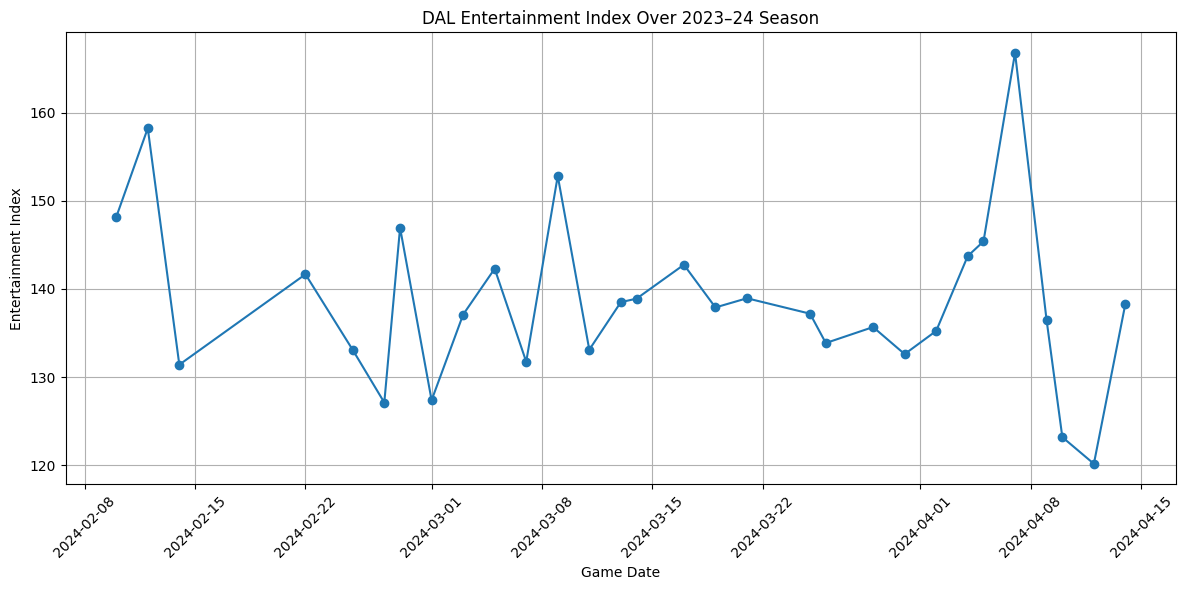

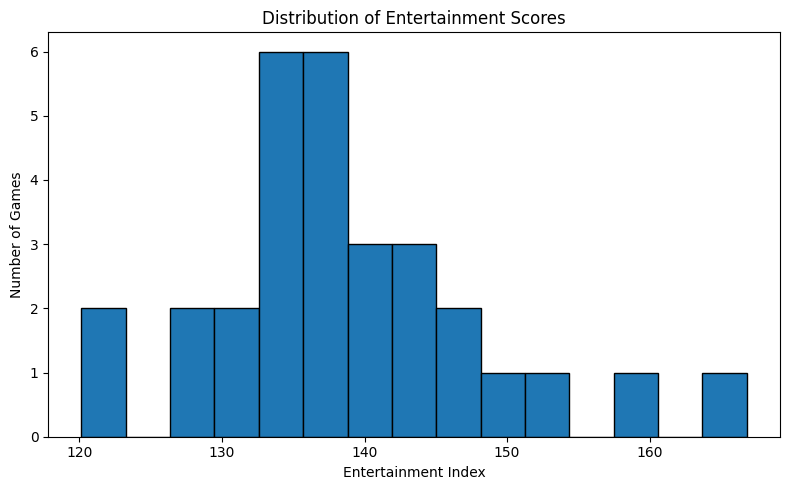

In [ ]:
# Line plot
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(entertainment_df['DATE']), entertainment_df['ENTERTAINMENT_INDEX'], marker='o')
plt.title(f"{team_name} Entertainment Index Over 2023–24 Season")
plt.xlabel("Game Date")
plt.ylabel("Entertainment Index")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(8, 5))
plt.hist(entertainment_df['ENTERTAINMENT_INDEX'], bins=15, edgecolor='black')
plt.title("Distribution of Entertainment Scores")
plt.xlabel("Entertainment Index")
plt.ylabel("Number of Games")
plt.tight_layout()
plt.show()


## Step 7: Comparing Entertainment Across Multiple Teams

Now that we’ve analyzed one team, we expand the project to include five high-profile NBA teams from the 2023–24 season:
- Boston Celtics
- Denver Nuggets
- Golden State Warriors
- Milwaukee Bucks
- Los Angeles Lakers

We will:
1. Pull all regular season games
2. Calculate the Entertainment Index for each
3. Label each row by team
4. Combine the data into one dataset


In [ ]:
from nba_api.stats.static import teams

# Select teams
team_names = ['Boston Celtics', 'Denver Nuggets', 'Golden State Warriors', 'Milwaukee Bucks', 'Los Angeles Lakers']
nba_teams = teams.get_teams()
team_ids = {team['full_name']: team['id'] for team in nba_teams if team['full_name'] in team_names}
team_ids

{'Boston Celtics': 1610612738,
 'Denver Nuggets': 1610612743,
 'Golden State Warriors': 1610612744,
 'Los Angeles Lakers': 1610612747,
 'Milwaukee Bucks': 1610612749}

## Step 7A: Compute Entertainment Scores for Each Team

We loop through each of the five selected teams and run the same analysis pipeline:
- Pull game, box score, summary, and play-by-play data
- Compute entertainment score based on our defined index
- Store game ID, opponent, date, team, and score

This may take a few minutes due to rate limiting (1.2 sec per request).


In [ ]:
from nba_api.stats.endpoints import leaguegamefinder, boxscoretraditionalv2, boxscoresummaryv2, playbyplayv2
import pandas as pd
import time

all_entertainment_data = []

# Let user know that the code is processing the team
for team_name, team_id in team_ids.items():
    print(f"Processing {team_name}...")

    # Get games for 2023–24 and filter to regular season
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id, season_nullable='2023-24')
    team_games = gamefinder.get_data_frames()[0]
    team_games = team_games[team_games['GAME_ID'].str.startswith('002')]  # regular season
    team_games = team_games.sort_values(by='GAME_DATE', ascending=False)
    recent_games = team_games.head(30)

    for i, row in recent_games.iterrows():
        game_id = row['GAME_ID']
        print(f"Game {i + 1}/10 — {row['MATCHUP']} on {row['GAME_DATE']}")
        try:
            # Pull data
            boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id).get_data_frames()[0]
            summary = boxscoresummaryv2.BoxScoreSummaryV2(game_id=game_id).get_data_frames()[5]
            pbp_df = playbyplayv2.PlayByPlayV2(game_id=game_id).get_data_frames()[0]


            t1 = summary.iloc[0]
            t2 = summary.iloc[1]

            q4_diff = abs(t1['PTS_QTR4'] - t2['PTS_QTR4'])
            stars = boxscore[boxscore['PTS'] >= 30]
            num_stars = len(stars)

            h1_t1 = t1['PTS_QTR1'] + t1['PTS_QTR2']
            h1_t2 = t2['PTS_QTR1'] + t2['PTS_QTR2']
            comeback = ((h1_t1 < h1_t2 and t1['PTS'] > t2['PTS']) or
                        (h1_t2 < h1_t1 and t2['PTS'] > t1['PTS']))

            pbp_df['SCOREMARGIN'] = pd.to_numeric(pbp_df['SCOREMARGIN'], errors='coerce')
            lead_changes = pbp_df['SCOREMARGIN'].dropna().ne(pbp_df['SCOREMARGIN'].shift()).sum()

            clutch_plays = pbp_df[
                (pbp_df['PCTIMESTRING'] <= '05:00') &
                (pbp_df['SCOREMARGIN'].abs() <= 5) &
                (pbp_df['EVENTMSGTYPE'].isin([1, 3]))]
            clutch_pts = 0
            for _, play in clutch_plays.iterrows():
                clutch_pts += 2 if play['EVENTMSGTYPE'] == 1 else 1

            final_fgas = pbp_df[(pbp_df['PCTIMESTRING'] <= '01:00') & (pbp_df['EVENTMSGTYPE'] == 1)]
            final_min_fga = len(final_fgas)

            ot_bonus = 1.5 if 'PTS_OT1' in t1 and t1.get('PTS_OT1', 0) > 0 else 0

            index = (
                (1 / (q4_diff + 1)) +
                (0.5 * num_stars) +
                (1 if comeback else 0) +
                ot_bonus +
                (0.3 * lead_changes) +
                (0.5 * clutch_pts) +
                (0.1 * final_min_fga))

            all_entertainment_data.append({
                'TEAM': team_name,
                'GAME_ID': game_id,
                'DATE': row['GAME_DATE'],
                'OPPONENT': row['MATCHUP'],
                'ENTERTAINMENT_INDEX': index})

            time.sleep(1.2)

        except Exception as e:
            print(f"Skipped {game_id}: {e}")
            continue


multi_team_df = pd.DataFrame(all_entertainment_data)
# Optional: Convert DATE column to datetime for cleaner formatting
multi_team_df['DATE'] = pd.to_datetime(multi_team_df['DATE'])

# Save to CSV with clean formatting
multi_team_df.to_csv('entertainment_scores_multi_team.csv', index=False)
multi_team_df.head(10)

Processing Boston Celtics...
Game 20/10 — BOS vs. WAS on 2024-04-14
Game 21/10 — BOS vs. CHA on 2024-04-12
Game 22/10 — BOS vs. NYK on 2024-04-11
Game 23/10 — BOS @ MIL on 2024-04-09
Game 24/10 — BOS vs. POR on 2024-04-07
Game 25/10 — BOS vs. SAC on 2024-04-05
Game 26/10 — BOS vs. OKC on 2024-04-03
Game 27/10 — BOS @ CHA on 2024-04-01
Game 28/10 — BOS @ NOP on 2024-03-30
Game 29/10 — BOS @ ATL on 2024-03-28
Game 30/10 — BOS @ ATL on 2024-03-25
Game 31/10 — BOS @ CHI on 2024-03-23
Game 32/10 — BOS @ DET on 2024-03-22
Game 33/10 — BOS vs. MIL on 2024-03-20
Game 34/10 — BOS vs. DET on 2024-03-18
Game 35/10 — BOS @ WAS on 2024-03-17
Game 36/10 — BOS vs. PHX on 2024-03-14
Game 37/10 — BOS @ UTA on 2024-03-12
Game 38/10 — BOS @ POR on 2024-03-11
Game 39/10 — BOS @ PHX on 2024-03-09
Game 40/10 — BOS @ DEN on 2024-03-07
Game 41/10 — BOS @ CLE on 2024-03-05
Game 42/10 — BOS vs. GSW on 2024-03-03
Game 43/10 — BOS vs. DAL on 2024-03-01
Game 44/10 — BOS vs. PHI on 2024-02-27
Game 45/10 — BOS @ NYK

,TEAM,GAME_ID,DATE,OPPONENT,ENTERTAINMENT_INDEX
0,Boston Celtics,0022301186,2024-04-14,BOS vs. WAS,129.611111
1,Boston Celtics,0022301173,2024-04-12,BOS vs. CHA,128.062500
2,Boston Celtics,0022301167,2024-04-11,BOS vs. NYK,125.047619
3,Boston Celtics,0022301148,2024-04-09,BOS @ MIL,109.533333
4,Boston Celtics,0022301134,2024-04-07,BOS vs. POR,124.600000
5,Boston Celtics,0022301118,2024-04-05,BOS vs. SAC,133.183333
6,Boston Celtics,0022301105,2024-04-03,BOS vs. OKC,133.238462
7,Boston Celtics,0022301087,2024-04-01,BOS @ CHA,124.833333
8,Boston Celtics,0022301074,2024-03-30,BOS @ NOP,122.650000
9,Boston Celtics,0022301060,2024-03-28,BOS @ ATL,145.900000


## Step 8: Visualizing and Comparing Team Entertainment

With entertainment scores for 5 teams now calculated, we will create several visualizations:

1. **Line plot**: Shows how entertainment levels varied across the season for each team.
2. **Box plot**: Compares the overall distribution of entertainment scores across teams.
3. **Top 5 Most Exciting Games**: Highlights the highest-rated games based on our index.


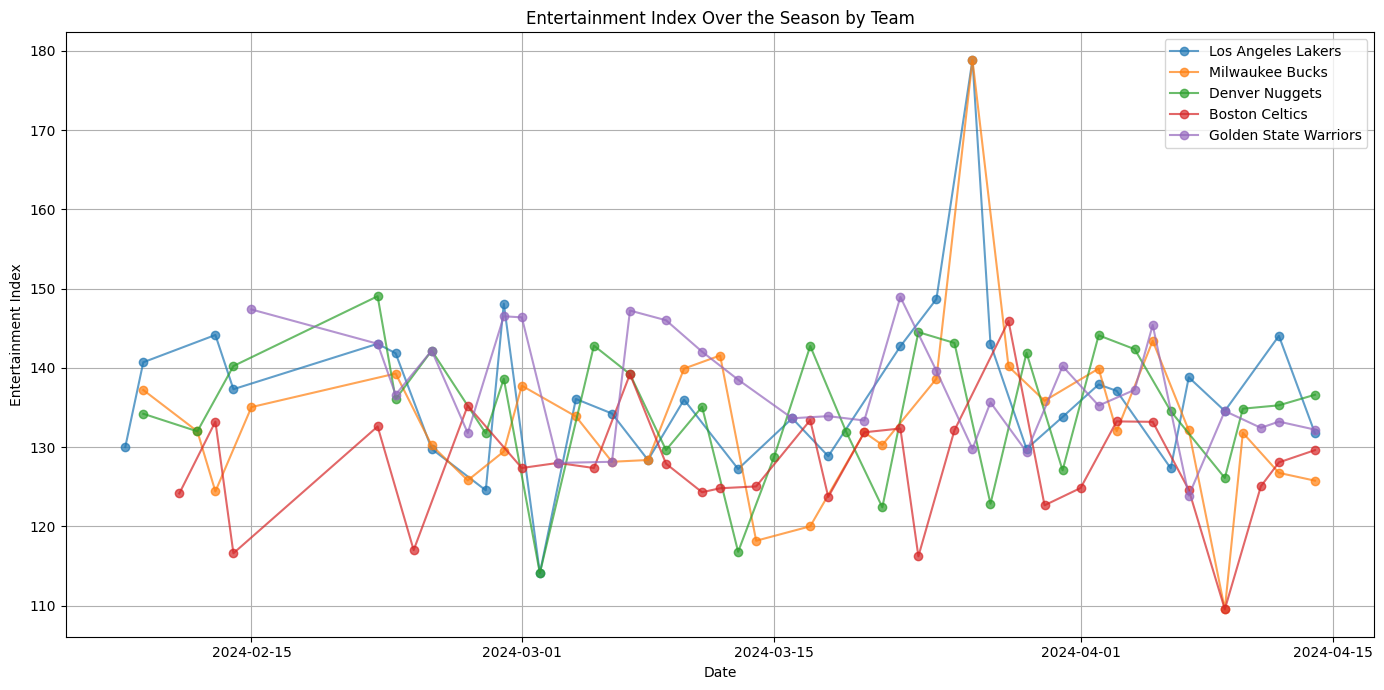

In [ ]:
import matplotlib.pyplot as plt

# Convert date column to datetime
multi_team_df['DATE'] = pd.to_datetime(multi_team_df['DATE'])

multi_team_df.sort_values(by='DATE', inplace=True)

# Line plot per team
plt.figure(figsize=(14, 7))
for team in multi_team_df['TEAM'].unique():
    team_data = multi_team_df[multi_team_df['TEAM'] == team]
    plt.plot(team_data['DATE'], team_data['ENTERTAINMENT_INDEX'], label=team, marker='o', alpha=0.7)

plt.title("Entertainment Index Over the Season by Team")
plt.xlabel("Date")
plt.ylabel("Entertainment Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

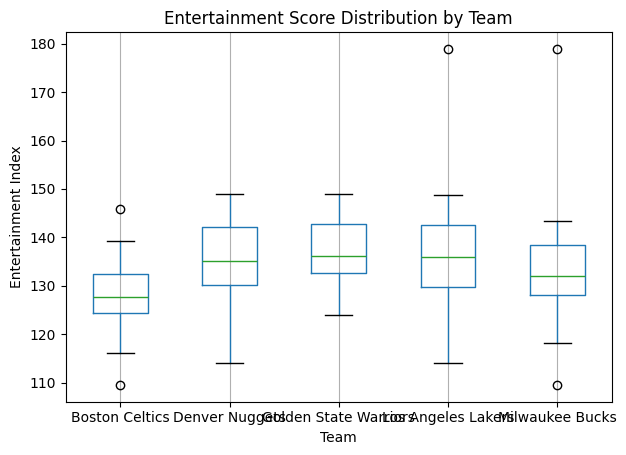

In [ ]:
plt.figure(figsize=(10, 6))
multi_team_df.boxplot(column='ENTERTAINMENT_INDEX', by='TEAM')
plt.title("Entertainment Score Distribution by Team")
plt.suptitle("")  # Remove default subtitle
plt.xlabel("Team")
plt.ylabel("Entertainment Index")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
top_5 = multi_team_df.sort_values(by='ENTERTAINMENT_INDEX', ascending=False).head(5)
top_5[['TEAM', 'OPPONENT', 'DATE', 'ENTERTAINMENT_INDEX']]

,TEAM,OPPONENT,DATE,ENTERTAINMENT_INDEX
130,Milwaukee Bucks,MIL vs. LAL,2024-03-26,178.866667
100,Los Angeles Lakers,LAL @ MIL,2024-03-26,178.866667
56,Denver Nuggets,DEN vs. WAS,2024-02-22,149.033333
73,Golden State Warriors,GSW vs. IND,2024-03-22,148.933333
101,Los Angeles Lakers,LAL vs. IND,2024-03-24,148.676923


## Step 9: Categorizing the Entertainment Index: What's High vs. Low?

To better interpret the entertainment score, we use **K-Means clustering** to group each game into one of three tiers:

- **Really High Entertainment**: Games with extremely intense scoring, lead changes, close finishes, or star performances.
- **High Entertainment**: Games with intense scoring, lead changes, close finishes, or star performances.
- **Medium Entertainment**: Games that have some excitement, but lack consistent drama or intensity.
- **Low Entertainment**: Blowouts, low-scoring matches, or games lacking clutch moments.

We apply K-Means clustering to all game scores and then visualize how many games each team had in each category.


## Step 10: Understanding the Thresholds

The K-Means clustering algorithm groups games based on the structure of their entertainment index scores.

Below, we print the actual **centroid values** (average Entertainment Index within each cluster). These help us understand where the boundaries lie between Low, Medium, High, and Really High entertainment games.

> Note: These thresholds were *learned* from the data — they are not manually set.


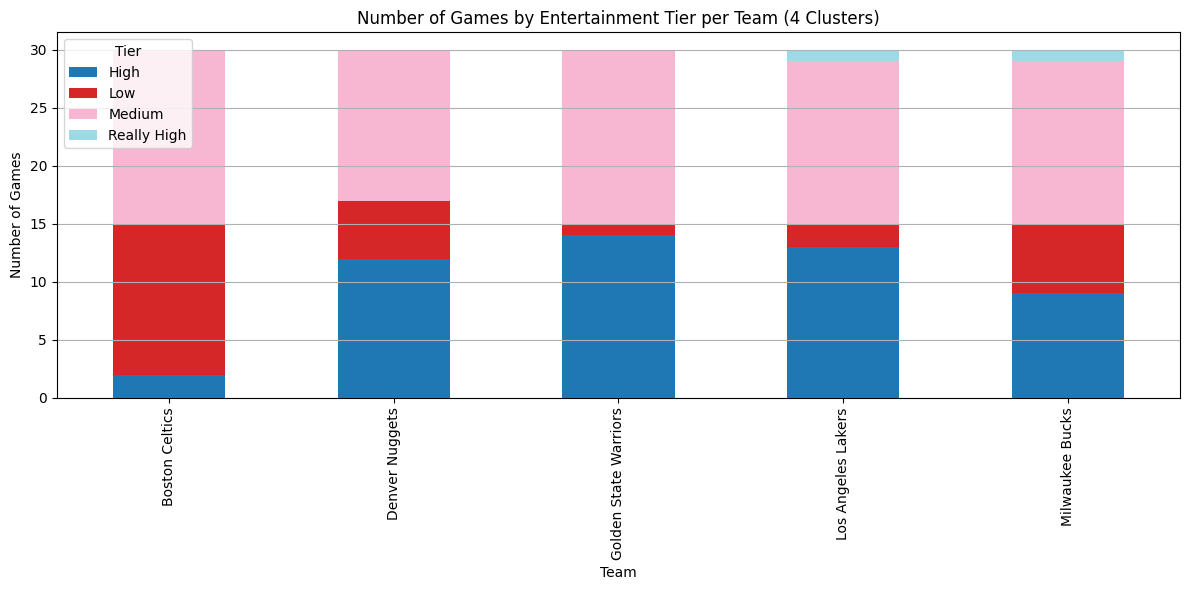

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Apply KMeans with 4 clusters
X = multi_team_df[['ENTERTAINMENT_INDEX']].copy()
kmeans = KMeans(n_clusters=4, random_state=42)
multi_team_df['CLUSTER'] = kmeans.fit_predict(X)
cluster_centers = kmeans.cluster_centers_.flatten()
labels = ['Low', 'Medium', 'High', 'Really High']  # 4 tiers

# Sort cluster centers to assign labels in ascending order
order = pd.Series(cluster_centers).sort_values().index.tolist()
label_mapping = {order[i]: labels[i] for i in range(4)}
multi_team_df['ENTERTAINMENT_LEVEL'] = multi_team_df['CLUSTER'].map(label_mapping)

multi_team_df.to_csv("entertainment_scores_with_4clusters.csv", index=False)

# Plotting
ent_summary = multi_team_df.groupby(['TEAM', 'ENTERTAINMENT_LEVEL']).size().unstack().fillna(0)
ent_summary.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab20')

plt.title("Number of Games by Entertainment Tier per Team (4 Clusters)")
plt.xlabel("Team")
plt.ylabel("Number of Games")
plt.legend(title="Tier")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Show thresholds and centroids
centroids = pd.Series(cluster_centers, index=[f"Cluster {i}" for i in range(4)])
centroids_sorted = centroids.sort_values()

print("Cluster Centroids (Entertainment Index Averages):")
for i, val in enumerate(centroids_sorted):
    label = labels[i]
    print(f"{label} Entertainment: {val:.2f}")

# Optional: Show value ranges in each cluster
for label in ['Low', 'Medium', 'High', 'Really High']:
    cluster_vals = multi_team_df[multi_team_df['ENTERTAINMENT_LEVEL'] == label]['ENTERTAINMENT_INDEX']
    print(f"\n{label} Entertainment Range:")
    print(f"Min: {cluster_vals.min():.2f}")
    print(f"Max: {cluster_vals.max():.2f}")
    print(f"Mean: {cluster_vals.mean():.2f}")


Cluster Centroids (Entertainment Index Averages):
Low Entertainment: 120.99
Medium Entertainment: 131.83
High Entertainment: 142.23
Really High Entertainment: 178.87

Low Entertainment Range:
Min: 109.53
Max: 126.10
Mean: 120.99

Medium Entertainment Range:
Min: 126.74
Max: 136.61
Mean: 131.83

High Entertainment Range:
Min: 137.09
Max: 149.03
Mean: 142.23

Really High Entertainment Range:
Min: 178.87
Max: 178.87
Mean: 178.87
